<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/AutoencoderBasico_Kaggle_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [1]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Descarga de Datos

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

### Kaggle

**Descargamos un dataset de kaggle para aumentar el número de imágenes de prueba**

Tiene las siguientes clases:

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR


A nosotros nos intersan las de la clase 0. 







In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diegorudiezgomez","key":"a97ea3f0837ef30e1012d50ea0d74929"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

**Tras relizar algunas configuraciones descargamos el dataset:**

In [8]:
%%time
! kaggle competitions download -c 'aptos2019-blindness-detection'

100% 9.51G/9.51G [01:07<00:00, 222MB/s]
100% 9.51G/9.51G [01:07<00:00, 151MB/s]
CPU times: user 985 ms, sys: 203 ms, total: 1.19 s
Wall time: 1min 8s


In [9]:
!unzip -qq aptos2019-blindness-detection.zip -d 'datasetKaggle'

In [10]:
datasetKaggle = 'datasetKaggle'

In [11]:
imgTrain = os.listdir(datasetKaggle + '/train_images')

In [12]:
datasetKaggle + '/train_images/' + imgTrain[0]

'datasetKaggle/train_images/300305ce82d2.png'

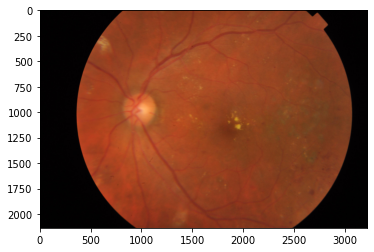

In [13]:
image = cv2.imread(datasetKaggle + '/train_images/' + imgTrain[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [14]:
df_trainKaggle = pd.read_csv(datasetKaggle + '/train.csv')

In [15]:
df_trainKaggle['diagnosis'].value_counts() #1805 imágenes sanas

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [16]:
df_trainKaggle.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


### Reto

**Ahora las del reto que hemos utilizado siempre.**

In [17]:
# !wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
# !wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
# !wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

In [18]:
# !rm -rvf Training_Set_Pre
# !unzip -qq train.zip #-qq no verbose
# !unzip -qq test.zip
# !unzip -qq val.zip

Descargamos el dataset sin procesar, para aplicar el mismo a los dos datsets

In [19]:
!wget https://www.dropbox.com/s/1isaa8xrrv0x6n4/datasetComprimido.zip?dl=0 --no-verbose -O datasetComp.zip

2022-06-23 11:12:31 URL:https://uc27eab04fc55481f8e8bcc206df.dl.dropboxusercontent.com/cd/0/inline2/BnupQDk18vZQiDjNAYuF3mUeEVBUL5fbA1xYrT-j8cO7usaGT48DDTXQI-Gk3LGR6TWIZ_bJgeXeI1ExMAb5wgAkdXKZ2jUZIiCVVlu4i_C6lO7M_4J9P-BolqkjzOkwXlRABG0fVAvrvcujUSHapjD3dnSY4M7cY4g_QA8m7ZOaW3nwRXxsYyIgHqs82Qhp_JbyB7ppj86HskXpnQN6WuXtkPzLsztwBHqj3-RGaimvNsCy0vFVs5AKekJ6Y92E2wq9eRxiWMVnUP8Obb0mMyJVNU97ujTb2D1OWoY310FnZl_4vgn2mk3GFJxEGe6fniV3N_Z9VcYouukm9Ce0guaHLmX17NTXbPIhDQwDn6d0wNZJttOM0axCuOQhM8Sltr0XEmqrQl0Yb8ZQ_Vcn4PrRjPfXhV-ChKBJVw_cPr-f9w/file [144922725/144922725] -> "datasetComp.zip" [1]


In [20]:
!unzip -qq datasetComp.zip

In [21]:
# trainPath = 'Training_Set_Pre/'
# testPath  = 'Test_Set_Pre/'
# valPath  =  'Evaluation_Set_Pre/'

In [22]:
trainPath = 'Training_Set_C/'
testPath  = 'Test_Set_C/'
valPath  =  'Evaluation_Set_C/'

## Preparación de Datos

In [25]:
IMG_SIZE = 64

### Funciones de procesado

In [23]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted(image,4, cv2.GaussianBlur(image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

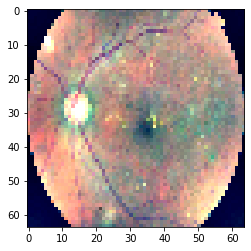

In [26]:
img = load_ben_color(datasetKaggle + '/train_images/' + imgTrain[0], 10)
plt.imshow(img)

### Datos Kaggle

In [56]:
import shutil

def getNpArrayKaggle(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['id_code'], df['diagnosis']):
    image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [57]:
normalKaggle, enfermedadKaggle = getNpArrayKaggle(df_trainKaggle, datasetKaggle + '/train_images')

In [29]:
normalKaggle.shape

(1805, 64, 64, 3)

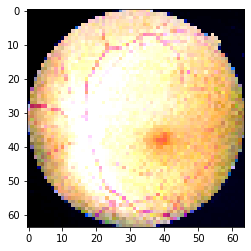

In [58]:
plt.imshow(normalKaggle[0])

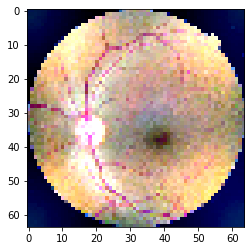

In [30]:
plt.imshow(normalKaggle[0])

### Datos Reto (el mismo de siempre)


In [62]:
import shutil

def getNpArray(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [63]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

In [64]:
normalTrain, enfermedadTrain = getNpArray(df_train, trainPath + 'Training/')
normalTest, enfermedadTest = getNpArray(df_test, testPath + 'Test/')
normalVal, enfermedadVal = getNpArray(df_val, valPath + 'Validation/')

In [34]:
normalTrain.shape

(401, 64, 64, 3)

In [35]:
normalTest.shape

(134, 64, 64, 3)

Ya la tenemos reescalada a la medida deseada:

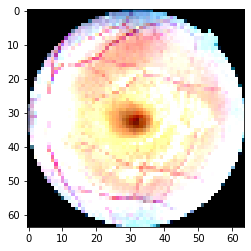

In [65]:
plt.imshow(normalTrain[0])

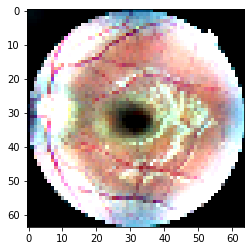

In [36]:
plt.imshow(normalTrain[0])

## Autoencoder

In [66]:
input_img = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))

### Encoder

In [76]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Capa de max pooling con filtro de tamaño 2x2 y aplicando padding
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

### Decoder

In [77]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
 # Capa de upsampling con filtro de tamaño 2x2 y aplicando padding
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [78]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [79]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 32)        9248

### Entrenamiento

In [80]:
dataNormalAll = np.concatenate([normalTrain, normalKaggle])

In [81]:
dataNormalAll.shape

(2206, 64, 64, 3)

In [82]:
autoencoder.fit(dataNormalAll, dataNormalAll,
                epochs=50,
                batch_size=128,
                validation_data=(normalVal, normalVal))

Epoch 1/50
18/18 [==============================] - 1s 40ms/step - loss: -443827.5938 - val_loss: -3104520.0000
Epoch 2/50
18/18 [==============================] - 1s 28ms/step - loss: -29778916.0000 - val_loss: -133430808.0000
Epoch 3/50
18/18 [==============================] - 1s 28ms/step - loss: -638991744.0000 - val_loss: -2107573504.0000
Epoch 4/50
18/18 [==============================] - 1s 28ms/step - loss: -6418821632.0000 - val_loss: -16772791296.0000
Epoch 5/50
18/18 [==============================] - 1s 28ms/step - loss: -38727270400.0000 - val_loss: -85699215360.0000
Epoch 6/50
18/18 [==============================] - 0s 28ms/step - loss: -165213372416.0000 - val_loss: -322235105280.0000
Epoch 7/50
18/18 [==============================] - 1s 28ms/step - loss: -547346481152.0000 - val_loss: -972851642368.0000
Epoch 8/50
18/18 [==============================] - 1s 28ms/step - loss: -1512377548800.0000 - val_loss: -2499294789632.0000
Epoch 9/50
18/18 [========================

### Pruebas

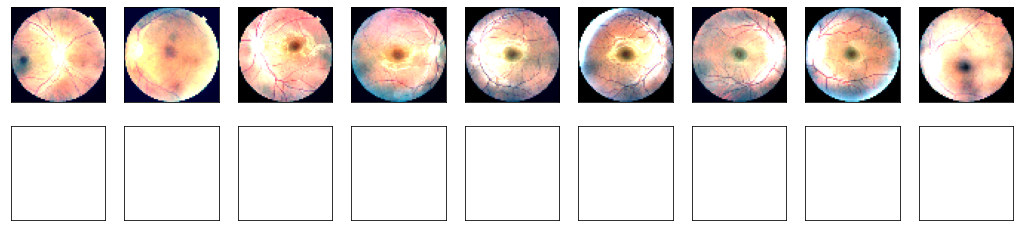

In [83]:
decoded_imgs = autoencoder.predict(normalTest)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(normalTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

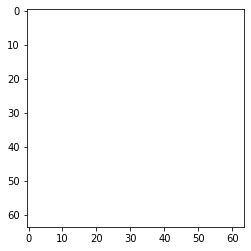

In [46]:
plt.imshow(decoded_imgs[0])

## Diferente Arquitectura

https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726

In [47]:
import numpy as np
from tensorflow import keras

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam

In [75]:
autoencoder = Sequential()
autoencoder.add(Dense(3, activation='elu', input_shape=(64,64,3)))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(3,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

trained_model = autoencoder.fit(dataNormalAll, dataNormalAll, batch_size=1024, epochs=60, verbose=1, validation_data=(normalVal, normalVal))

Epoch 1/60
3/3 [==============================] - 2s 432ms/step - loss: 32641.3594 - val_loss: 33018.3828
Epoch 2/60
3/3 [==============================] - 1s 332ms/step - loss: 32613.4062 - val_loss: 33017.6719
Epoch 3/60
3/3 [==============================] - 1s 346ms/step - loss: 32612.7285 - val_loss: 33017.5234
Epoch 4/60
3/3 [==============================] - 1s 334ms/step - loss: 32612.5801 - val_loss: 33017.4648
Epoch 5/60
3/3 [==============================] - 1s 334ms/step - loss: 32612.5254 - val_loss: 33017.4375
Epoch 6/60
3/3 [==============================] - 1s 332ms/step - loss: 32612.4961 - val_loss: 33017.4219
Epoch 7/60
3/3 [==============================] - 1s 330ms/step - loss: 32612.4824 - val_loss: 33017.4062
Epoch 8/60
3/3 [==============================] - 1s 328ms/step - loss: 32612.4707 - val_loss: 33017.3984
Epoch 9/60
3/3 [==============================] - 1s 328ms/step - loss: 32612.4648 - val_loss: 33017.3867
Epoch 10/60
3/3 [=============================

In [49]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(normalTrain)  # bottleneck representation
decoded_output = autoencoder.predict(normalTrain)        # reconstruction
encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

In [50]:
predicts = autoencoder.predict(normalTest)

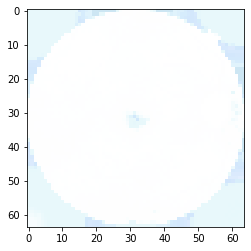

In [51]:
plt.imshow(predicts[4])

In [54]:
predicts = autoencoder.predict(enfermedadTest)

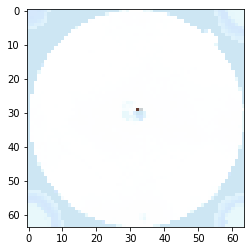

In [55]:
plt.imshow(predicts[4])

## Otra alternativa

In [52]:
model = keras.Sequential(
    [
        layers.Input(shape=(normalTrain.shape[1], normalTrain.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=64, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 32, 32)            14368     
                                                                 
 dropout (Dropout)           (None, 32, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 32, 16)           1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 32, 16)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 64, 32)           3616      
 ranspose)                                            

In [53]:
model.fit(
    normalTrain,
    normalTrain,
    epochs=50,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50


ValueError: ignored

## Otra arquitectura diferente

https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

In [ ]:
inputs = tf.keras.Input(shape=(64, 64, 3), name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [ ]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

In [ ]:
hist=autoencoder.fit(dataNormalAll, dataNormalAll,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(normalVal, normalVal)
                )

In [ ]:
predicts = autoencoder.predict(normalTest)

In [ ]:
plt.imshow(predicts[6])

In [ ]:
predicts = autoencoder.predict(enfermedadTest)

In [ ]:
plt.imshow(predicts[70])